<a href="https://colab.research.google.com/github/Mateo289/Signal_theory/blob/main/3_Febrero_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


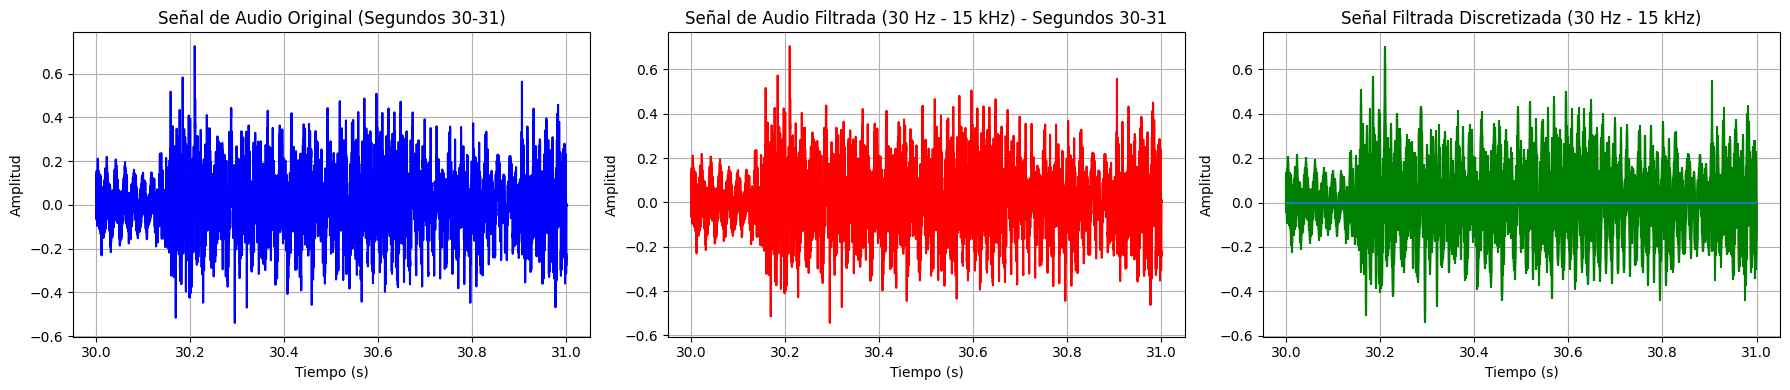

In [134]:
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from IPython.display import Audio
from scipy.signal import butter, filtfilt
from matplotlib import rcParams

# Montar Google Drive
drive.mount('/content/drive')

# Configurar parámetros globales
ruta_audio = "/content/drive/MyDrive/Audios/At-First-Sight-FiftySounds.wav"

# Leer archivo de audio
audio_signal, sample_rate = sf.read(ruta_audio)

# Si el audio tiene más de un canal, tomar solo el primer canal
if len(audio_signal.shape) > 1:
    audio_signal = audio_signal[:, 0]

# Calcular el número de muestras correspondientes a los segundos 30-31
inicio_muestra = int(30 * sample_rate)
fin_muestra = int(31 * sample_rate)

# Tomar los segundos 30-31 del audio original
audio_segmento_original = audio_signal[inicio_muestra:fin_muestra]

# Definir filtro Butterworth de 4to orden pasa-banda entre [30 Hz, 15 kHz]
low_cut_freq = 30.0     # 30 Hz
high_cut_freq = 15000.0 # 15 kHz
nyquist = sample_rate / 2.0
low_norm = low_cut_freq / nyquist
high_norm = high_cut_freq / nyquist
b, a = butter(N=4, Wn=[low_norm, high_norm], btype='band')

# Aplicar el filtro con filtfilt (para no introducir retraso de fase)
audio_signal_filtered = filtfilt(b, a, audio_signal)

# Tomar solo los segundos 30-31 del audio filtrado
audio_segmento_filtrado = audio_signal_filtered[inicio_muestra:fin_muestra]

# Crear eje de tiempo para los segundos 30-31
time_segmento = np.linspace(30, 31, num=len(audio_segmento_original))

# Discretización de la señal filtrada
sampling_rate = 30000  # Frecuencia de muestreo en Hz
sampling_period = 1 / sampling_rate
time_discrete = np.arange(30, 31, sampling_period)  # Tiempos discretos
audio_discrete = np.interp(time_discrete, time_segmento, audio_segmento_filtrado)  # Interpolación de la señal

# Crear figura con tres subgráficos: original, filtrada y discretizada
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# Gráfico de la señal original
axs[0].plot(time_segmento, audio_segmento_original, color='b')
axs[0].set_title('Señal de Audio Original (Segundos 30-31)')
axs[0].set_xlabel('Tiempo (s)')
axs[0].set_ylabel('Amplitud')
axs[0].grid(True)

# Gráfico de la señal filtrada
axs[1].plot(time_segmento, audio_segmento_filtrado, color='r')
axs[1].set_title('Señal de Audio Filtrada (30 Hz - 15 kHz) - Segundos 30-31')
axs[1].set_xlabel('Tiempo (s)')
axs[1].set_ylabel('Amplitud')
axs[1].grid(True)

# Gráfico de la señal discretizada
axs[2].stem(time_discrete, audio_discrete, linefmt='g-', markerfmt='', basefmt='')
axs[2].set_title('Señal Filtrada Discretizada (30 Hz - 15 kHz)')
axs[2].set_xlabel('Tiempo (s)')
axs[2].set_ylabel('Amplitud')
axs[2].grid(True)

# Ajustar diseño para mejor visualización
plt.tight_layout()
plt.show()

# Reproducir los segundos 30-31 de la señal original
Audio(audio_segmento_original, rate=sample_rate)


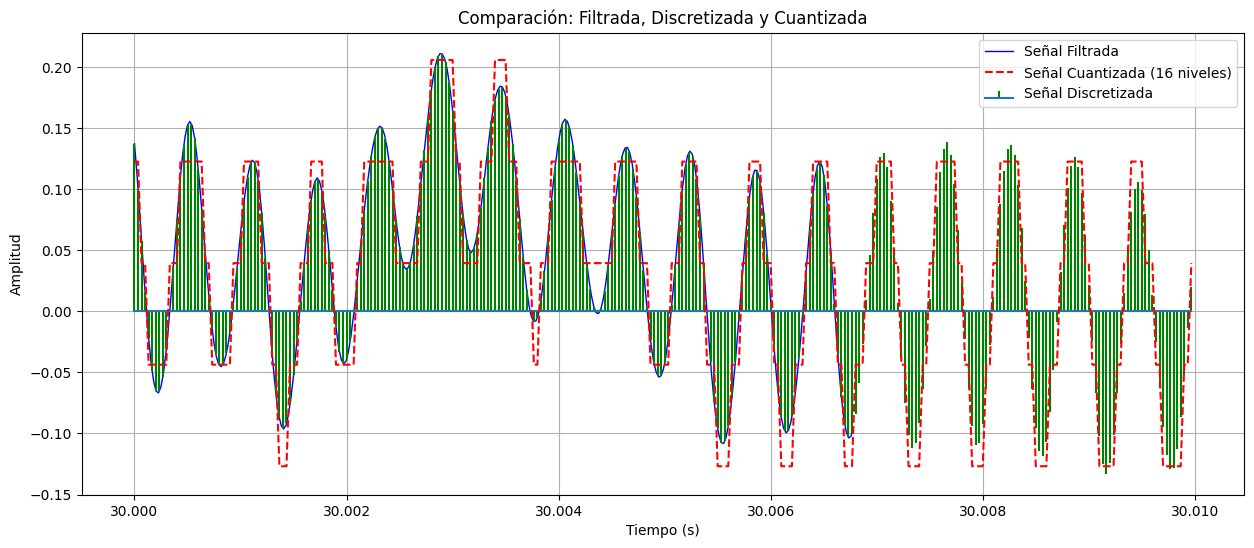

In [135]:
# Cuantización uniforme de la señal discretizada (16 niveles, 4 bits)
levels_uniforme = 16
q_min = np.min(audio_discrete)  # Determina el mínimo de la señal
q_max = np.max(audio_discrete)  # Determina el máximo de la señal

def quantize_uniform(x, q_min=-1.0, q_max=1.0, q_level=16):
    x_normalize = (x - q_min) * (q_level - 1) / (q_max - q_min)
    x_normalize = np.clip(x_normalize, 0, q_level - 1)
    x_quant = np.round(x_normalize) * (q_max - q_min) / (q_level - 1) + q_min
    return x_quant

audio_cuantizada = quantize_uniform(audio_discrete, q_min, q_max, levels_uniforme)

# Graficar todas las señales superpuestas
plt.figure(figsize=(15, 6))

# Señal Filtrada
plt.plot(time_segmento[:300], audio_segmento_filtrado[:300], label="Señal Filtrada", color="blue", linewidth=1)

# Señal Discretizada (usando stem)
plt.stem(time_discrete[:300], audio_discrete[:300], label="Señal Discretizada", linefmt="green", markerfmt="", basefmt="")

# Señal Cuantizada (línea continua interpolada)
plt.plot(time_discrete[:300], audio_cuantizada[:300], label="Señal Cuantizada (16 niveles)", color="red", linewidth=1.5, linestyle='--')

# Configurar gráfico
plt.title("Comparación: Filtrada, Discretizada y Cuantizada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.show()


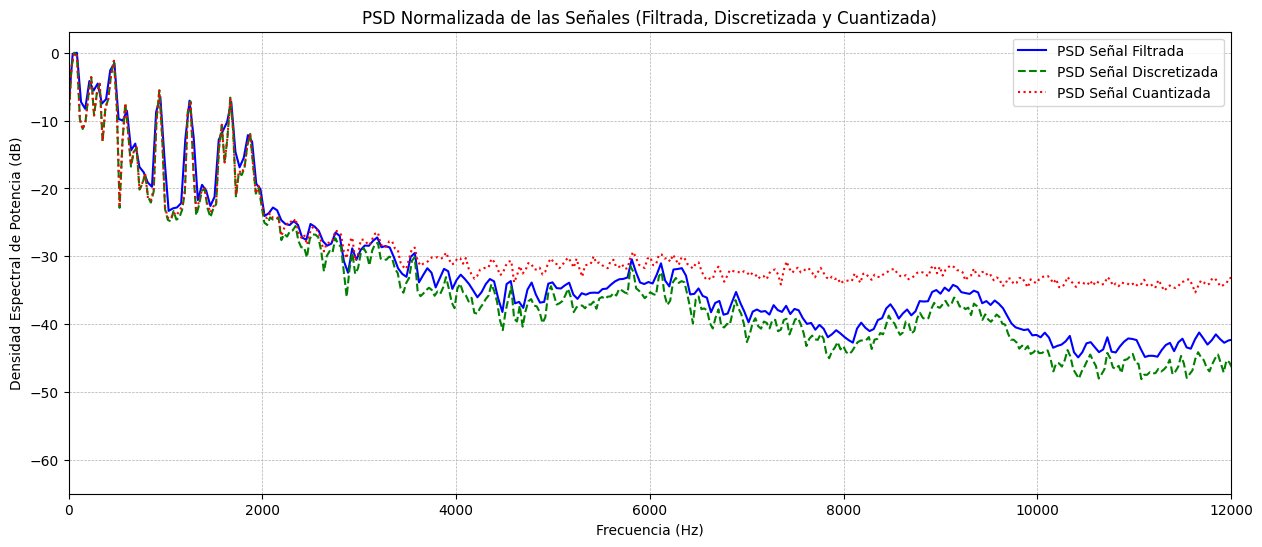

In [136]:
from scipy.signal import welch

# Calcular PSD para la señal filtrada
frequencies_filtrada, psd_filtrada = welch(audio_segmento_filtrado, fs=sample_rate, nperseg=1024)
psd_filtrada_normalizada = 10 * np.log10(psd_filtrada / np.max(psd_filtrada))  # Normalización a 0 dB

# Calcular PSD para la señal discretizada
frequencies_discretizada, psd_discretizada = welch(audio_discrete, fs=sampling_rate, nperseg=1024)
psd_discretizada_normalizada = 10 * np.log10(psd_discretizada / np.max(psd_discretizada))  # Normalización a 0 dB

# Calcular PSD para la señal cuantizada
frequencies_cuantizada, psd_cuantizada = welch(audio_cuantizada, fs=sampling_rate, nperseg=1024)
psd_cuantizada_normalizada = 10 * np.log10(psd_cuantizada / np.max(psd_cuantizada))  # Normalización a 0 dB

# Limitar las frecuencias a 15 kHz
max_freq_index_filtrada = np.where(frequencies_filtrada <= 15000)[0][-1]
max_freq_index_discretizada = np.where(frequencies_discretizada <= 15000)[0][-1]
max_freq_index_cuantizada = np.where(frequencies_cuantizada <= 15000)[0][-1]

frequencies_filtrada = frequencies_filtrada[:max_freq_index_filtrada + 1]
psd_filtrada_normalizada = psd_filtrada_normalizada[:max_freq_index_filtrada + 1]

frequencies_discretizada = frequencies_discretizada[:max_freq_index_discretizada + 1]
psd_discretizada_normalizada = psd_discretizada_normalizada[:max_freq_index_discretizada + 1]

frequencies_cuantizada = frequencies_cuantizada[:max_freq_index_cuantizada + 1]
psd_cuantizada_normalizada = psd_cuantizada_normalizada[:max_freq_index_cuantizada + 1]

# Graficar las PSD normalizadas
plt.figure(figsize=(15, 6))
plt.plot(frequencies_filtrada, psd_filtrada_normalizada, label="PSD Señal Filtrada", color="blue", linewidth=1.5)
plt.plot(frequencies_discretizada, psd_discretizada_normalizada, label="PSD Señal Discretizada", color="green", linewidth=1.5, linestyle="--")
plt.plot(frequencies_cuantizada, psd_cuantizada_normalizada, label="PSD Señal Cuantizada", color="red", linewidth=1.5, linestyle=":")

# Configuración del gráfico
plt.title("PSD Normalizada de las Señales (Filtrada, Discretizada y Cuantizada)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Densidad Espectral de Potencia (dB)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.xlim([0, 12000])  # Limitar el eje x a 15 kHz
plt.show()



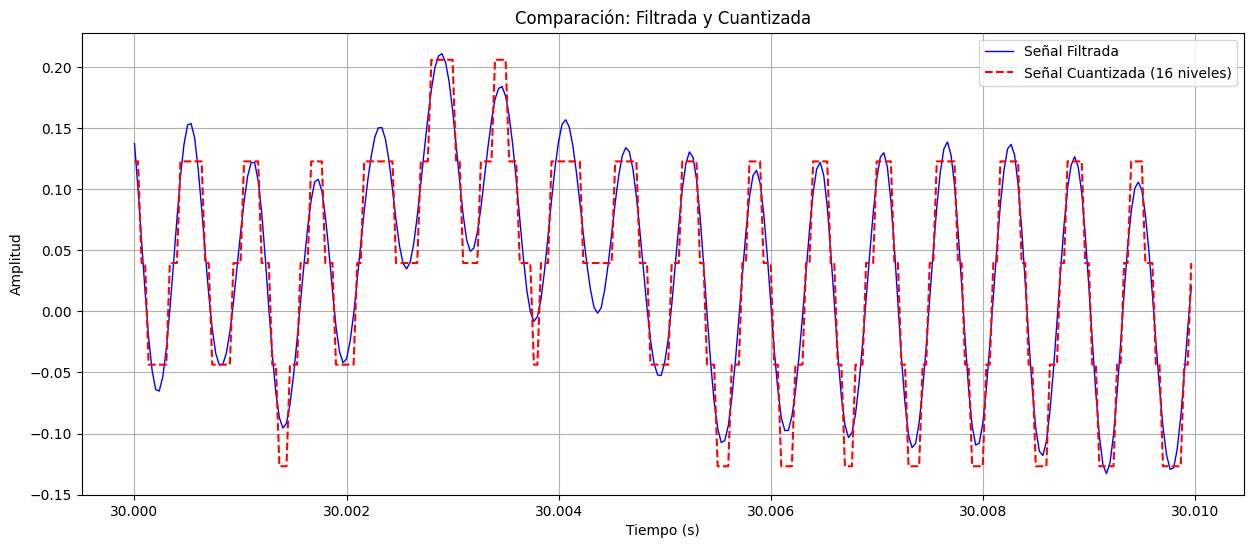

In [137]:
# Extender el tiempo del segmento filtrado al rango del tiempo discreto
# Se interpolará la señal filtrada para que coincida en longitud con la señal cuantizada
time_segmento_extendido = np.linspace(time_segmento[0], time_segmento[-1], len(time_discrete))
audio_segmento_filtrado_extendido = np.interp(time_segmento_extendido, time_segmento, audio_segmento_filtrado)

# Graficar todas las señales superpuestas
plt.figure(figsize=(15, 6))

# Señal Filtrada (interpolada para extender su rango)
plt.plot(time_segmento_extendido[:300], audio_segmento_filtrado_extendido[:300], label="Señal Filtrada", color="blue", linewidth=1)

# Señal Cuantizada (línea continua interpolada)
plt.plot(time_discrete[:300], audio_cuantizada[:300], label="Señal Cuantizada (16 niveles)", color="red", linewidth=1.5, linestyle='--')

# Configurar gráfico
plt.title("Comparación: Filtrada y Cuantizada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.show()


Cantidad de muestras para la cuantización fija (tavo = 1): 30000
Cantidad de muestras para la discretización variable (tavo = 0.5): 15000
Cantidad de muestras para la cuantización variable (tavo = 0.5): 15000


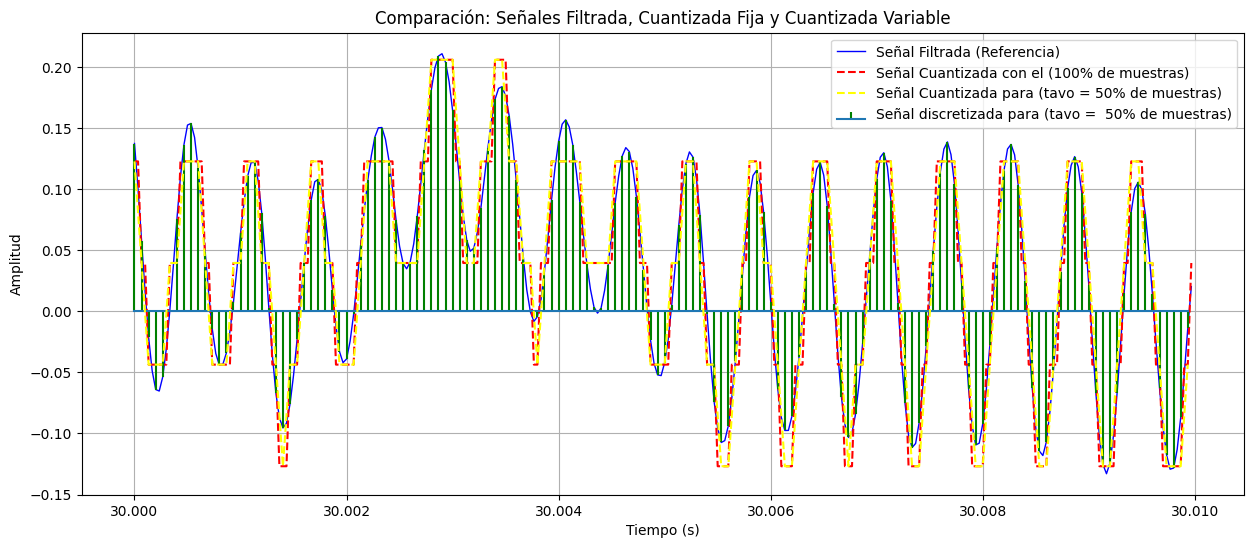

In [142]:
# Discretización y cuantización fija con tavo = 1
tavo_fijo = 1
sampling_rate_fijo = tavo_fijo * 30000  # Frecuencia de muestreo en Hz
sampling_period_fijo = 1 / sampling_rate_fijo
time_discrete_fijo = np.arange(30, 31, sampling_period_fijo)  # Tiempos discretos
audio_discrete_fijo = np.interp(time_discrete_fijo, time_segmento, audio_segmento_filtrado)  # Interpolación de la señal
audio_cuantizada_fijo = quantize_uniform(audio_discrete_fijo, q_min, q_max, levels_uniforme)

# Discretización y cuantización variable
tavo_variable = 0.5  # Cambia este valor dinámicamente entre (0,1]
sampling_rate_variable = tavo_variable * 30000  # Frecuencia de muestreo en Hz
sampling_period_variable = 1 / sampling_rate_variable
time_discrete_variable = np.arange(30, 31, sampling_period_variable)  # Tiempos discretos
audio_discrete_variable = np.interp(time_discrete_variable, time_segmento, audio_segmento_filtrado)  # Interpolación de la señal
audio_cuantizada_variable = quantize_uniform(audio_discrete_variable, q_min, q_max, levels_uniforme)

# Extender el tiempo del segmento filtrado al rango del tiempo discreto
time_segmento_extendido = time_discrete_fijo  # Usar los tiempos de la señal fija
audio_segmento_filtrado_extendido = np.interp(time_segmento_extendido, time_segmento, audio_segmento_filtrado)

# Imprimir las cantidades de muestras utilizadas
print(f"Cantidad de muestras para la cuantización fija (tavo = 1): {len(audio_cuantizada_fijo)}")
print(f"Cantidad de muestras para la discretización variable (tavo = {tavo_variable}): {len(audio_discrete_variable)}")
print(f"Cantidad de muestras para la cuantización variable (tavo = {tavo_variable}): {len(audio_cuantizada_variable)}")

# Graficar todas las señales superpuestas
plt.figure(figsize=(15, 6))

# Señal Filtrada (Referencia fija)
plt.plot(time_segmento_extendido[:300], audio_segmento_filtrado_extendido[:300], label="Señal Filtrada (Referencia)", color="blue", linewidth=1)

# Señal Cuantizada fija (Referencia para tavo = 1)
plt.plot(time_discrete_fijo[:300], audio_cuantizada_fijo[:300], label="Señal Cuantizada con el (100% de muestras)", color="red", linewidth=1.5, linestyle='--')

# Señal Discretizada variable (Cambia con tavo)
plt.stem(time_discrete_variable[:int(tavo_variable * 300)], audio_discrete_variable[:int(tavo_variable * 300)],
         label=f"Señal discretizada para (tavo =  {int(tavo_variable * 100)}% de muestras)", linefmt="green", markerfmt="", basefmt="")

# Señal Cuantizada variable (Cambia con tavo)
plt.plot(time_discrete_variable[:int(tavo_variable * 300)], audio_cuantizada_variable[:int(tavo_variable * 300)],
         label=f"Señal Cuantizada para (tavo = {int(tavo_variable * 100)}% de muestras)", color="yellow", linewidth=1.5, linestyle='--')

# Configurar gráfico
plt.title("Comparación: Señales Filtrada, Cuantizada Fija y Cuantizada Variable")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.show()
